# **NLP Project Classification**
*By: WAAD ALQAHTANI*



# **Incident Response System: Classification and Action Suggestion**

This project aims to develop a system that can automatically classify incident descriptions and suggest appropriate actions for emergency response. Utilizing a multi-output deep learning model based on an Encoder-Decoder architecture with Attention, the system processes textual incident reports to:

1.  **Classify** the incident into relevant categories (e.g., fire, medical emergency, traffic).
2.  **Suggest** a corresponding action message for the dispatched departments.

The notebook covers the entire process from data loading and exploratory data analysis (EDA), through text preprocessing (tokenization and padding), model building and training, to model evaluation and prediction. The goal is to demonstrate how deep learning can be applied to automate parts of the emergency response workflow. [link text](https://)

In [1]:
# import required tools
import pandas as pd
import re
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

# **Load & EDA Dataset**

In [2]:
# import datset from files

import pandas as pd
data = pd.read_csv('/content/generated_incident_dataset_50k.csv')
data.head(10)

,description,summary,label,action,response
0,Fire reported in a building at 7488 Stephen Sp...,Summary: Fire reported in a building at 7488 S...,['fire'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
1,A person fainted near 7028 Graham Bypass Apt. ...,Summary: A person fainted near 7028 Graham Byp...,['ambulance'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
2,Vehicle breakdown causing traffic near 9944 An...,Summary: Vehicle breakdown causing traffic nea...,['traffic'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
3,A person fainted near 8537 Reynolds Mills Apt....,Summary: A person fainted near 8537 Reynolds M...,['ambulance'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
4,Fire reported in a building at 6828 Christina ...,Summary: Fire reported in a building at 6828 C...,['fire'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
5,Smoke seen coming out from the window at 1137 ...,Summary: Smoke seen coming out from the window...,['fire'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
6,Smoke seen coming out from the window at 144 J...,Summary: Smoke seen coming out from the window...,['fire'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
7,Housebreaking reported in 30217 Haynes Straven...,Summary: Housebreaking reported in 30217 Hayne...,"['fire', 'police']",Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
8,Medical emergency reported at 5162 Jennifer Fo...,Summary: Medical emergency reported at 5162 Je...,['ambulance'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...
9,Vehicle breakdown causing traffic near 35539 H...,Summary: Vehicle breakdown causing traffic nea...,['traffic'],Action: Dispatch nearest unit to location imme...,Response: We have received your report and dis...


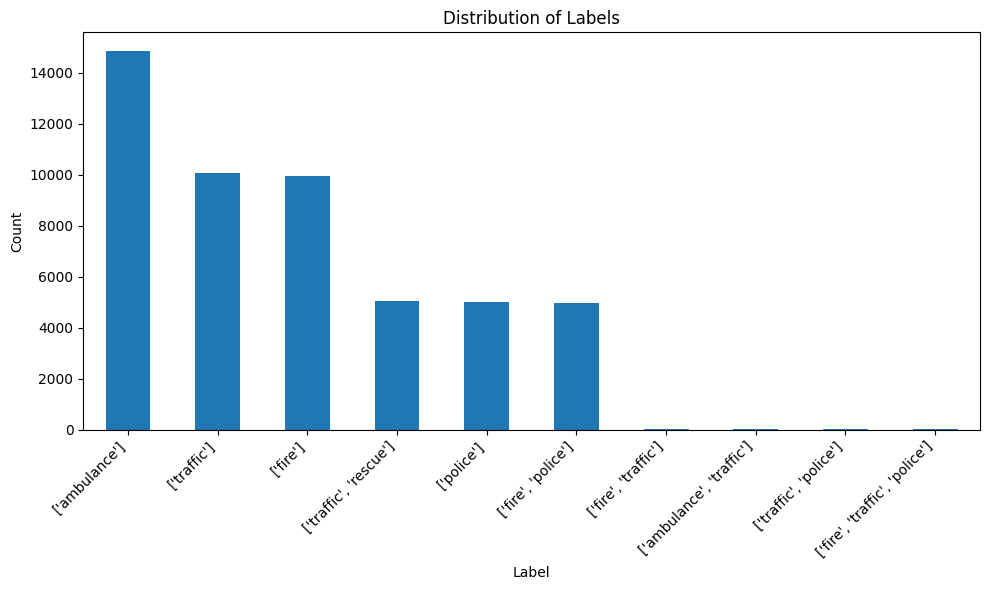

In [3]:
# prompt: plot for label

import matplotlib.pyplot as plt

# Get the value counts of the 'label' column
label_counts = data['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
# Ensure proper format for multi-label classification
data['label'] = data['label'].apply(eval)  # convert string list to actual list

In [5]:
# Binarize the labels (multi-label format)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['label'])

Number of records: 50000

Missing values:
 description    0
summary        0
label          0
action         0
response       0
dtype: int64

Class distribution of 'label':
 label
traffic      15221
fire         14982
ambulance    14881
police       10026
rescue        5043
Name: count, dtype: int64


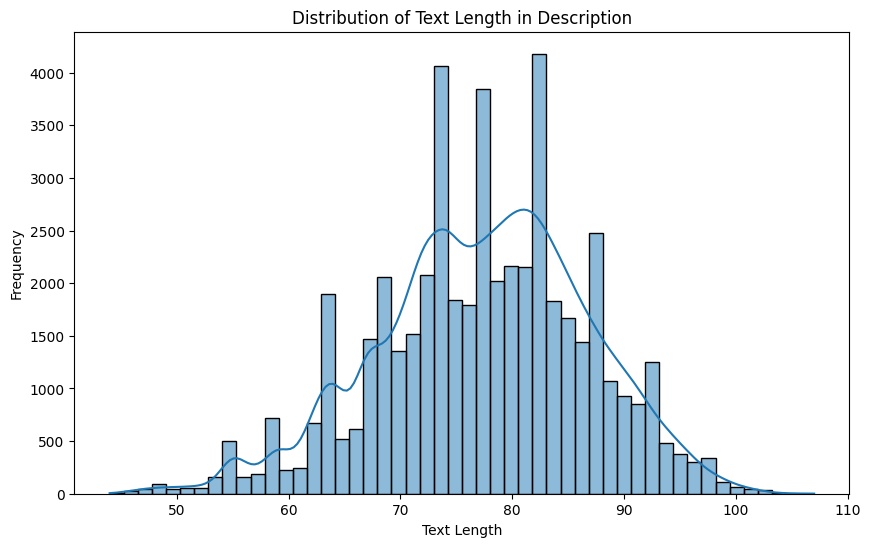

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Show the number of records and missing values
print("Number of records:", data.shape[0])
print("\nMissing values:\n", data.isnull().sum())

# Display class distribution of the ‘target’ column (assuming 'label' is the target)
print("\nClass distribution of 'label':\n", data['label'].explode().value_counts())

# Plot the distribution of text length in the 'description' column
data['text_length'] = data['description'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length in Description')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()




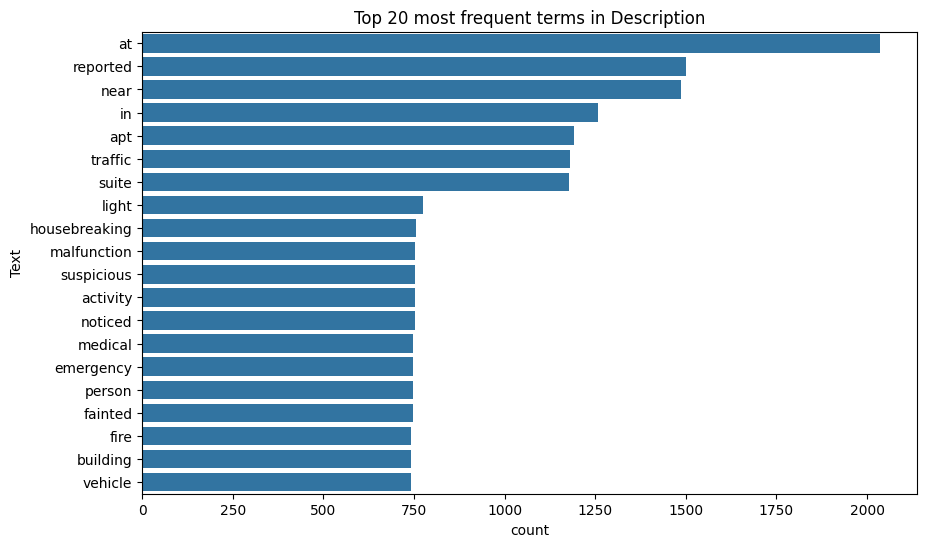

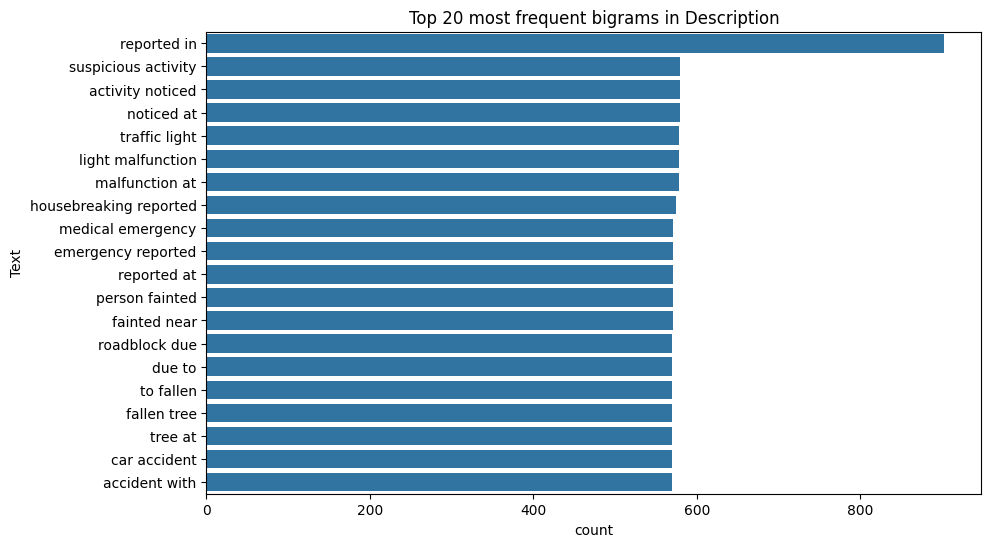

In [7]:
# Frequency of words in descriptions
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['description'], 20)
df_common_words = pd.DataFrame(common_words, columns = ['Text','count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='Text', data=df_common_words)
plt.title('Top 20 most frequent terms in Description')
plt.show()

# n-gram analysis (example for bigrams)
def get_top_n_bigrams(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_bigrams = get_top_n_bigrams(data['description'], 20)
df_common_bigrams = pd.DataFrame(common_bigrams, columns = ['Text','count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='Text', data=df_common_bigrams)
plt.title('Top 20 most frequent bigrams in Description')
plt.show()

# Add more NLP-specific EDA as needed, e.g., analyzing punctuation, stopwords, sentiment if applicable.
# This depends on the nature of the 'description' text.

In [8]:
# prompt: count labels and missing values

# Show the number of records and missing values
print("Number of records:", data.shape[0])
print("\nMissing values:\n", data.isnull().sum())

# Display class distribution of the ‘target’ column (assuming 'label' is the target)
print("\nClass distribution of 'label':\n", data['label'].explode().value_counts())

Number of records: 50000

Missing values:
 description    0
summary        0
label          0
action         0
response       0
text_length    0
dtype: int64

Class distribution of 'label':
 label
traffic      15221
fire         14982
ambulance    14881
police       10026
rescue        5043
Name: count, dtype: int64



Distribution of individual labels:


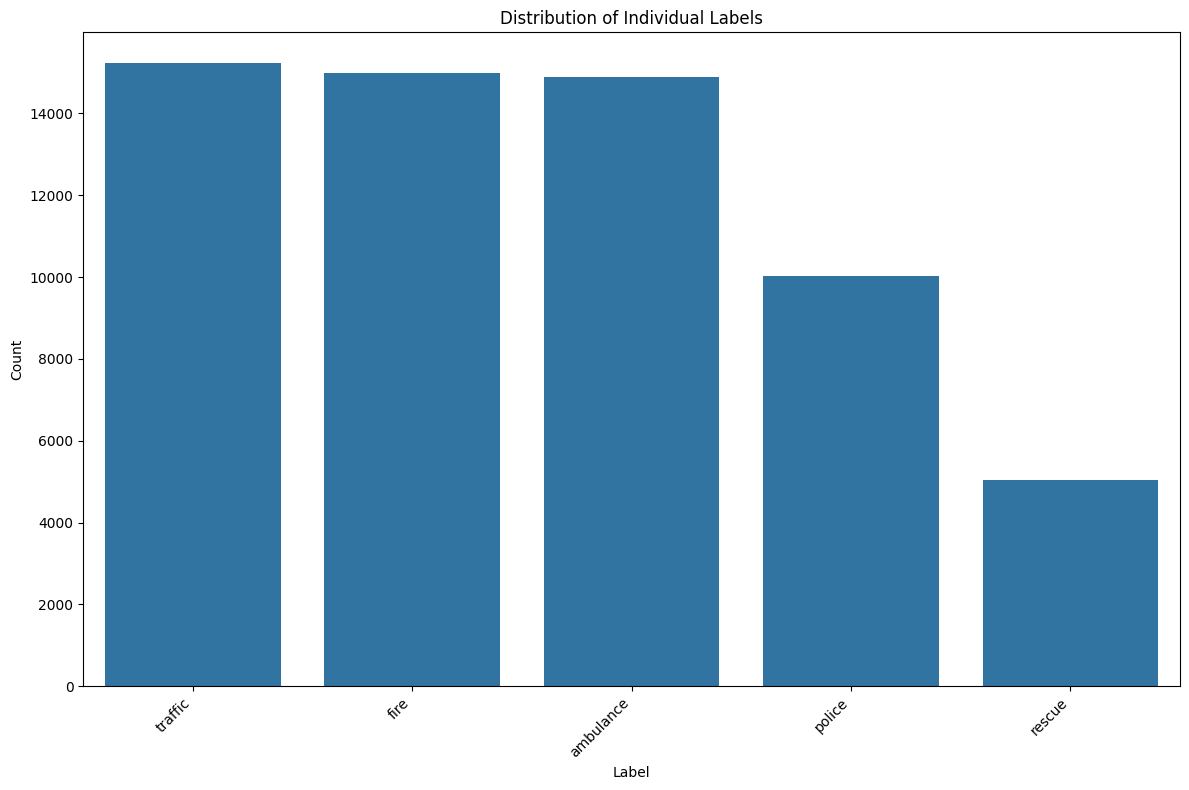

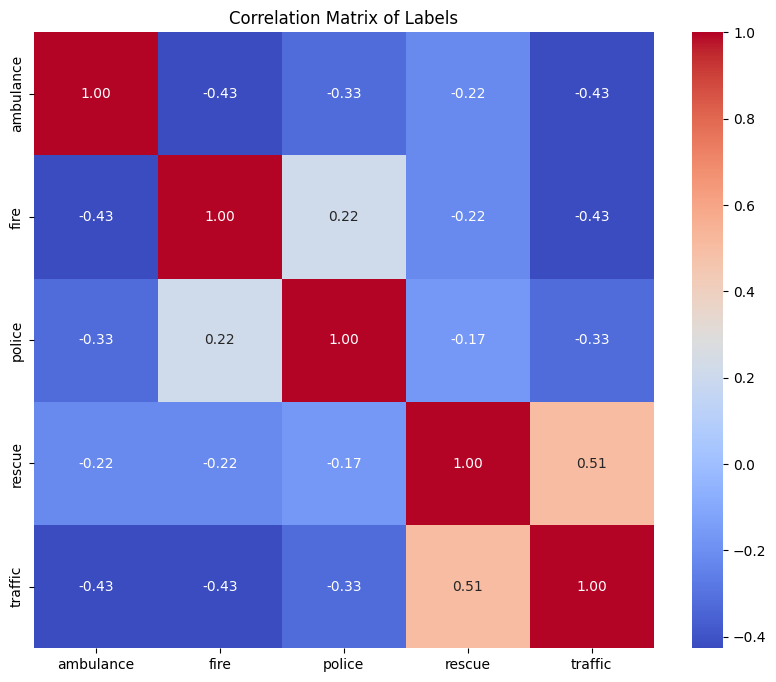

In [9]:
# EDA FOR Label columns

import pandas as pd
import matplotlib.pyplot as plt
# Display class distribution of the individual labels
print("\nDistribution of individual labels:")
label_counts = Counter(label for labels in data['label'] for label in labels)
label_counts_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts_df.index, y='count', data=label_counts_df)
plt.title('Distribution of Individual Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display correlation matrix between labels
label_correlation = data['label'].explode().groupby(level=0).agg(list)
mlb_corr = MultiLabelBinarizer()
label_matrix = mlb_corr.fit_transform(label_correlation)
label_df = pd.DataFrame(label_matrix, columns=mlb_corr.classes_)

correlation_matrix = label_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Labels')
plt.show()

#**Tokenization & Padding**

Tokenize the 'description' & 'Action' columns and define the tokenizer and maximum sequence length for padding.

In [10]:
# Tokenize the 'description' column
tokenizer_desc = Tokenizer()
tokenizer_desc.fit_on_texts(data['description'])
vocab_size = len(tokenizer_desc.word_index) + 1
max_desc_length = max([len(seq.split()) for seq in data['description']])

print("Description vocabulary size:", vocab_size)
print("Maximum description length:", max_desc_length)

Description vocabulary size: 72579
Maximum description length: 17


In [11]:
# Tokenize the 'action' column
tokenizer_action = Tokenizer()
tokenizer_action.fit_on_texts(data['action'])
max_action_length = max([len(seq.split()) for seq in data['action']])

print("Action vocabulary size:", len(tokenizer_action.word_index) + 1)
print("Maximum action length:", max_action_length)

Action vocabulary size: 8
Maximum action length: 7


In [12]:
# Prepare data for classification
# Assuming 'padded_description' is already created from preprocessing
# and 'y' contains the binarized labels

# Add tokenization and padding steps
# Assuming tokenizer_desc and max_desc_length are defined in previous cells
description_sequences = tokenizer_desc.texts_to_sequences(data['description'])
data['padded_description'] = pad_sequences(description_sequences, maxlen=max_desc_length, padding='post', truncating='post').tolist()


X_classification = np.array(data['padded_description'].tolist())
y_classification = y # 'y' was created in a previous cell using MultiLabelBinarizer

# Split data for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

print("Classification training data shape:", X_train_cls.shape)
print("Classification testing data shape:", X_test_cls.shape)
print("Classification training labels shape:", y_train_cls.shape)
print("Classification testing labels shape:", y_test_cls.shape)

Classification training data shape: (40000, 17)
Classification testing data shape: (10000, 17)
Classification training labels shape: (40000, 5)
Classification testing labels shape: (10000, 5)


## **Model Buliding and Training (Multi-classes)**

*   Model is  Encoder-Decoder with Attention layer architecture

*   Define and train a multi-output model capable of performing incident classification and action suggestion.

In [13]:
# Define the model architecture (Encoder-Decoder with Attention - modified)
from tensorflow.keras.layers import TimeDistributed # Import TimeDistributed layer
from tensorflow.keras.layers import GlobalAveragePooling1D # Import GlobalAveragePooling1D layer


embedding_dim = 128
lstm_units = 64

# Encoder
input_layer = Input(shape=(max_desc_length,), name='description_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)
# Use return_sequences=True to get outputs for attention
encoder_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(embedding_layer)

# Concatenate forward and backward states for the initial decoder state
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder for Action (keeping this)
decoder_inputs_action = Input(shape=(max_action_length,), name='action_input')
decoder_embedding_action = Embedding(input_dim=len(tokenizer_action.word_index) + 1, output_dim=embedding_dim)(decoder_inputs_action)
decoder_lstm_action = LSTM(lstm_units * 2, return_sequences=True, return_state=True)
decoder_outputs_action, _, _ = decoder_lstm_action(decoder_embedding_action, initial_state=encoder_states)

# Attention mechanism for action (keeping this)
attention_action = tf.keras.layers.Attention()([decoder_outputs_action, encoder_outputs])
context_vector_action = Concatenate(axis=-1)([decoder_outputs_action, attention_action])
action_branch = Dense(lstm_units * 2, activation='relu')(context_vector_action)
action_output = TimeDistributed(Dense(len(tokenizer_action.word_index) + 1, activation='softmax'), name='action_output')(action_branch)


# Output layer for Department Classification (connected to encoder outputs - keeping this)
# Using GlobalAveragePooling to reduce time dimension before classification
classification_input = GlobalAveragePooling1D()(encoder_outputs)
num_labels = y.shape[1]
classification_output = Dense(num_labels, activation='sigmoid', name='classification_output')(classification_input)

# Create the modified model
model = Model(inputs=[input_layer, decoder_inputs_action],
              outputs=[classification_output, action_output])

model.summary()

# Compile the model (adjusting loss and metrics for removed outputs)
model.compile(optimizer='adam',
              loss={'classification_output': 'binary_crossentropy',
                    'action_output': 'sparse_categorical_crossentropy'},
              metrics={'classification_output': 'accuracy',
                       'action_output': 'sparse_categorical_accuracy'})


# Example data preparation for action (assuming data['action'] exists)
action_sequences = tokenizer_action.texts_to_sequences(data['action'])
padded_action = pad_sequences(action_sequences, maxlen=max_action_length, padding='post', truncating='post')


# Split data for classification and action tasks
X_train, X_test, y_classification_train, y_classification_test, X_train_action, X_test_action = train_test_split(
    X_classification, y_classification, padded_action, test_size=0.2, random_state=42
)


# Train the modified model
history = model.fit(
    [X_train, X_train_action],
    {'classification_output': y_classification_train,
     'action_output': X_train_action}, # Using padded target sequences as output
    epochs=15,  # Adjust epochs as needed
    batch_size=32, # Adjust batch size as needed
    validation_data=(
        [X_test, X_test_action],
        {'classification_output': y_classification_test,
         'action_output': X_test_action} # Using padded target sequences as output
    )
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ description_input   │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 17, 128)   │  9,290,112 │ description_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 17, 128), │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ action_input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 7, 128)    │      1,024 │ action_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 7, 128),  │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ concatenate[0][0… │
│                     │ (None, 128)]      │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 7, 128)    │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 7, 256)    │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 7, 128)    │     32,896 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 5)         │        645 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ action_output       │ (None, 7, 8)      │      1,032 │ dense[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,556,109 (36.45 MB)

 Trainable params: 9,556,109 (36.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - action_output_loss: 0.1462 - action_output_sparse_categorical_accuracy: 0.9666 - classification_output_accuracy: 0.8095 - classification_output_loss: 0.1315 - loss: 0.2777 - val_action_output_loss: 3.9660e-06 - val_action_output_sparse_categorical_accuracy: 1.0000 - val_classification_output_accuracy: 0.7985 - val_classification_output_loss: 0.0028 - val_loss: 0.0028
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - action_output_loss: 8.7551e-06 - action_output_sparse_categorical_accuracy: 1.0000 - classification_output_accuracy: 0.8721 - classification_output_loss: 0.0013 - loss: 0.0013 - val_action_output_loss: 1.0915e-06 - val_action_output_sparse_categorical_accuracy: 1.0000 - val_classification_output_accuracy: 0.8978 - val_classification_output_loss: 2.3686e-04 - val_loss: 2.3805e-04
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - action_output_loss: 1.0671e-06 - action_output_sparse_categorical_accuracy

In [14]:
# Get action predictions from the model on the test set
# The model outputs are classification and action
# model.predict returns a list of arrays, where each array corresponds to an output head.
# The first element [0] is classification output, the second [1] is action output.
y_pred_action_probs = model.predict([X_test, X_test_action])[1]


# Convert action probabilities to predicted token indices
# For sequence generation, we typically take the token with the highest probability at each time step
y_pred_action_tokens = np.argmax(y_pred_action_probs, axis=-1)

print("Shape of predicted action token indices:", y_pred_action_tokens.shape)
print("Example of predicted action token indices:\n", y_pred_action_tokens[:5])

# You can convert these token indices back to words if needed for qualitative analysis
# using tokenizer_action.index_word

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Shape of predicted action token indices: (10000, 7)
Example of predicted action token indices:
 [[1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]]


#**Model evaluation**

Evaluate the performance of the model on a separate test set for each tasks.

In [15]:
# Evaluate the model
# The model now has only two outputs: classification and action
loss, classification_loss, action_loss, classification_accuracy, action_accuracy = model.evaluate(
    [X_test, X_test_action],
    {'classification_output': y_classification_test,
     'action_output': X_test_action}
)

print(f"Overall Loss: {loss}")
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {classification_accuracy}")
print(f"Action Loss: {action_loss}")
print(f"Action Sparse Categorical Accuracy: {action_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - action_output_loss: 7.6679e-07 - action_output_sparse_categorical_accuracy: 1.0000 - classification_output_accuracy: 0.8952 - classification_output_loss: 1.3271e-06 - loss: 2.0939e-06
Overall Loss: 2.1752712200395763e-06
Classification Loss: 1.4063648450246546e-06
Classification Accuracy: 1.0
Action Loss: 7.667157433388638e-07
Action Sparse Categorical Accuracy: 0.8978000283241272


## **Classification Evaluation**

Evaluate the performance of the Department Classification task using appropriate metrics such as precision, recall, F1-score, and confusion matrix.

In [16]:
from sklearn.metrics import classification_report

# Predict probabilities for classification on the test set
# Need to provide dummy inputs for the other branches of the multi-input model
# In this modified model, we only have description input and action input
dummy_action_input_test = np.zeros((X_test.shape[0], max_action_length))


# Predict in batches to avoid OOM error
batch_size = 64 # Adjust batch size based on your GPU memory
y_pred_probs_list = []

for i in range(0, X_test.shape[0], batch_size):
    X_test_batch = X_test[i:i + batch_size]
    dummy_action_input_batch = dummy_action_input_test[i:i + batch_size]

    # Get only the classification output from the model's prediction
    # Classification output is the first output [0]
    y_pred_probs_batch = model.predict([X_test_batch, dummy_action_input_batch])[0]
    y_pred_probs_list.append(y_pred_probs_batch)

y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)


# Convert probabilities to predicted labels using a threshold (e.g., 0.5)
y_pred_cls = (y_pred_probs > 0.5).astype(int)

# Generate and print the classification report
# mlb.classes_ provides the original label names
print("Classification Report:")
print(classification_report(y_classification_test, y_pred_cls, target_names=mlb.classes_))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━

Confusion Matrix for label: ambulance
[[7042    0]
 [   0 2958]]
--------------------
Confusion Matrix for label: fire
[[7004    0]
 [   0 2996]]
--------------------
Confusion Matrix for label: police
[[7993    0]
 [   0 2007]]
--------------------
Confusion Matrix for label: rescue
[[8981    0]
 [   0 1019]]
--------------------
Confusion Matrix for label: traffic
[[6939    0]
 [   0 3061]]
--------------------


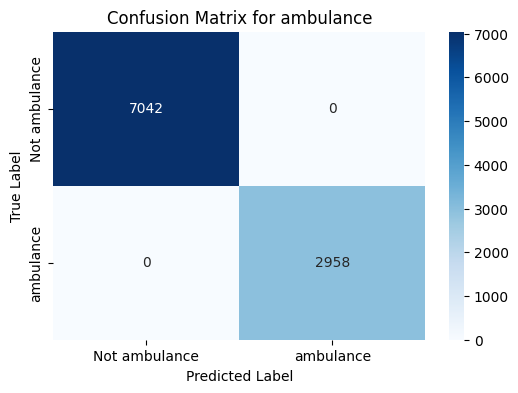

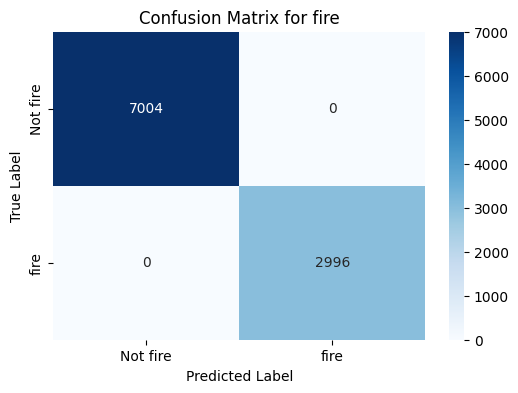

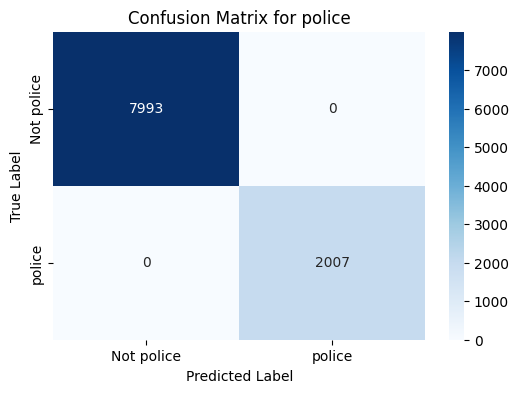

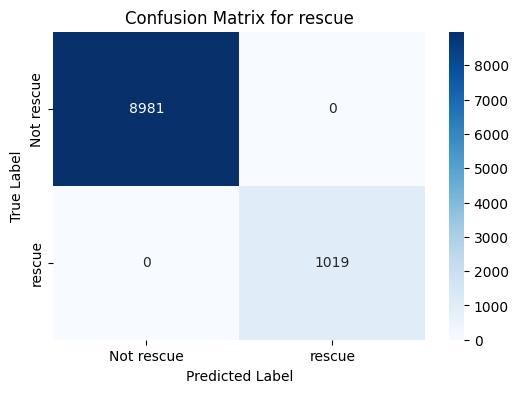

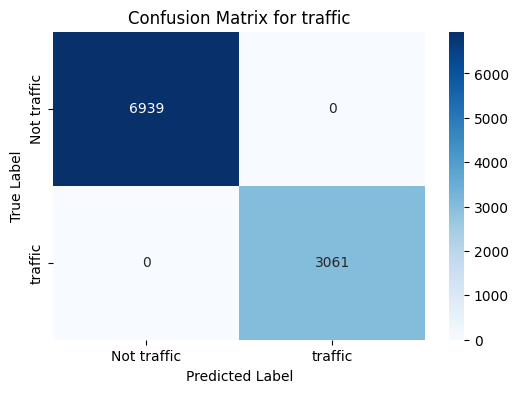

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix for each label
confusion_matrices = multilabel_confusion_matrix(y_classification_test, y_pred_cls)

# Display confusion matrix for each label
for i, label in enumerate(mlb.classes_):
    print(f"Confusion Matrix for label: {label}")
    print(confusion_matrices[i])
    print("-" * 20)

# Here's an example of how to plot them individually:

for i, label in enumerate(mlb.classes_):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not ' + label, label], yticklabels=['Not ' + label, label])
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## **Model Prediction (Classification)**

Use the trained model to predict the incident labels for a new, unseen incident description.

In [18]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [19]:
# Prediction function for Classification

def predict_incident_classification(description, model, tokenizer_desc, mlb, max_desc_length=100, max_action_length=50): # Removed location parameter
    # Preprocess the input description
    cleaned_description = clean_text(description)
    sequence = tokenizer_desc.texts_to_sequences([cleaned_description])
    padded_sequence = pad_sequences(sequence, maxlen=max_desc_length, padding='post', truncating='post')

    # To get only the classification output from the multi-output model,
    # we need to provide dummy inputs for the other branches.
    # In the modified model, only the action input is needed as a dummy
    dummy_action_input = np.zeros((padded_sequence.shape[0], max_action_length))

    # Predict using the main model and get only the first output (classification)
    # Predict in batches to avoid potential OOM errors on GPU, even for a single sample
    batch_size = 1 # Since we are predicting for a single new incident
    y_pred_probs_list = []

    for i in range(0, padded_sequence.shape[0], batch_size):
        X_batch = padded_sequence[i:i + batch_size]
        dummy_action_input_batch = dummy_action_input[i:i + batch_size]

        # Pass all expected inputs to model.predict()
        # The model now expects only two inputs: description and action
        y_pred_probs_batch = model.predict([X_batch, dummy_action_input_batch])[0] # Removed location_input_batch
        y_pred_probs_list.append(y_pred_probs_batch)

    y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)
    classification_probs = y_pred_probs[0] # Get the probabilities for the first (and only) sample


    # Convert probabilities to predicted labels using a threshold (e.g., 0.5)
    predicted_labels_indices = np.where(classification_probs > 0.5)[0] # Using 0.5 as a threshold

    # Handle the case where no labels are predicted
    if len(predicted_labels_indices) == 0:
        predicted_labels = ["None"] # Or a more appropriate placeholder
    else:
        predicted_labels_binary = np.zeros((1, len(mlb.classes_)))
        predicted_labels_binary[0, predicted_labels_indices] = 1
        predicted_labels = mlb.inverse_transform(predicted_labels_binary)[0]

    return predicted_labels

# Example usage:
new_incident_description = "There is a car crash with injuries on the highway."
# Removed location from the function call
predicted_labels = predict_incident_classification(
    new_incident_description,
    model,
    tokenizer_desc,
    mlb,
    max_desc_length,
    max_action_length
)

print(f"Incident Description: {new_incident_description}")
print(f"Predicted Labels: {predicted_labels}")

# Example with a different description
new_incident_description_2 = "Smoke is coming from the apartment building on Elm Street."
# Removed location from the function call
predicted_labels_2 = predict_incident_classification(
    new_incident_description_2,
    model,
    tokenizer_desc,
    mlb,
    max_desc_length,
    max_action_length
)

print(f"\nIncident Description: {new_incident_description_2}")
print(f"Predicted Labels: {predicted_labels_2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
Incident Description: There is a car crash with injuries on the highway.
Predicted Labels: ('ambulance',)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Incident Description: Smoke is coming from the apartment building on Elm Street.
Predicted Labels: ('fire',)


In [21]:
# Use the predict_incident_classification function on the first 10 samples of the original data
num_samples_to_evaluate = 10 # Define the number of samples to evaluate
print("Predicting classification for the first 10 samples from the original dataset:")
for i in range(min(num_samples_to_evaluate, X_test.shape[0])):
    description = data['description'].iloc[i]
    true_labels = data['label'].iloc[i] # Get the true labels
    # We need a dummy location for testing since the original data doesn't have it directly in this format
    dummy_location = "0.0, 0.0" # Replace with appropriate dummy data if needed

    predicted_labels = predict_incident_classification(
        description,
        model,
        tokenizer_desc,
        mlb,
        max_desc_length,
        max_action_length
    )

    print(f"\nSample {i+1}:")
    print(f"  Description: {description}")
    print(f"  True Labels: {true_labels}")
    print(f"  Predicted Labels: {list(predicted_labels)}") # Convert tuple to list for consistent output format

# You can also add evaluation metrics for these specific samples if needed,
# but typically you would evaluate on a separate test set for a robust assessment.

Predicting classification for the first 10 samples from the original dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Sample 1:
  Description: Fire reported in a building at 7488 Stephen Spur, Lucasmouth, OH 82543.
  True Labels: ['fire']
  Predicted Labels: ['fire']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Sample 2:
  Description: A person fainted near 7028 Graham Bypass Apt. 904, Port Jorgeville, HI 97802.
  True Labels: ['ambulance']
  Predicted Labels: ['ambulance']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Sample 3:
  Description: Vehicle breakdown causing traffic near 9944 Andre Flats Apt. 012, Kellyburgh, WI 61372.
  True Labels: ['traffic']
  Predicted Labels: ['traffic']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Sample 4:
  Description: A person fainted near 8537 Reynolds Mills Apt. 577, Lake Matthewstad, ND 68847.
  True Labels: ['ambulance']
  Predicted Labels: ['ambulance']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Sample 5:
  Description: Fire reported in a building at 6828 Christina 

## Save the Model
Save the trained multi-output model.

In [22]:
# Save the model
model.save('incident_response_model.keras')
print("Model saved successfully.")

Model saved successfully.


## **Action Message Generation**

Generate a simple action message based on the predicted incident classification labels.

In [23]:
# Function to generate a simple action message based on classification

def generate_action_message(predicted_labels): # Removed location parameter
    if not predicted_labels or "None" in predicted_labels:
        base_message = "Unable to determine the appropriate action based on the incident description."
    elif len(predicted_labels) == 1:
        # Handle singular case, maybe adjust phrasing
        department = predicted_labels[0].replace('_', ' ').title() # Make it more readable
        base_message = f"{department} has been dispatched to the site."
    else:
        # Handle multiple departments
        departments = [label.replace('_', ' ').title() for label in predicted_labels]
        departments_str = ", ".join(departments)
        base_message = f"{departments_str} have been dispatched to the site."

    # Removed location information if available
    return base_message

# Example usage:
# Assume predicted_labels is obtained from the classification prediction function

# Example 1: Fire department classified
predicted_labels_1 = ('Fire',)
action_message_1 = generate_action_message(predicted_labels_1) # Removed location
print(f"Predicted Labels: {predicted_labels_1}")
print(f"Generated Action Message: {action_message_1}")

# Example 2: Traffic and Police classified
predicted_labels_2 = ('Traffic', 'Police')
action_message_2 = generate_action_message(predicted_labels_2) # Removed location
print(f"\nPredicted Labels: {predicted_labels_2}")
print(f"Generated Action Message: {action_message_2}")

# Example 3: No specific labels classified
predicted_labels_3 = ('None',)
action_message_3 = generate_action_message(predicted_labels_3) # Removed location
print(f"\nPredicted Labels: {predicted_labels_3}")
print(f"Generated Action Message: {action_message_3}")

# Example 4: Using the actual classification prediction function output (without location)
new_incident_description = "There is a car crash with injuries on the highway."

# Note: The predict_incident_classification function currently returns only labels.
# To get location into the action message, you would need to pass it from where
# the prediction is called. For this example, we'll simulate passing the location.
# Also, the predict_incident_classification function will also need to be updated
# to no longer require location input for the prediction itself.
predicted_labels_from_model = predict_incident_classification(
    new_incident_description,
    model, # Removed dummy location argument
    tokenizer_desc,
    mlb,
    max_desc_length,
    max_action_length
)
action_message_from_model = generate_action_message(predicted_labels_from_model) # Removed location
print(f"\nIncident Description: {new_incident_description}")
print(f"Predicted Labels (from model): {predicted_labels_from_model}")
print(f"Generated Action Message (from model): {action_message_from_model}")

Predicted Labels: ('Fire',)
Generated Action Message: Fire has been dispatched to the site.

Predicted Labels: ('Traffic', 'Police')
Generated Action Message: Traffic, Police have been dispatched to the site.

Predicted Labels: ('None',)
Generated Action Message: Unable to determine the appropriate action based on the incident description.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Incident Description: There is a car crash with injuries on the highway.
Predicted Labels (from model): ('ambulance',)
Generated Action Message (from model): Ambulance has been dispatched to the site.


In [31]:
# Assuming X_test, y_classification_test, X_test_action, data, mlb,
# predict_incident_classification, and generate_action_message
# are available from previous cells.

# Select a few samples from the test set for qualitative evaluation
num_samples_to_evaluate = 10 # Evaluate the first 10 samples of the test set

print(f"\nQualitative Evaluation of Generated Action Messages (based on predicted labels) for the first {num_samples_to_evaluate} test samples:")

for i in range(min(num_samples_to_evaluate, X_test.shape[0])):


    # Get description and true labels from original data
    description = data['description'].iloc[i]
    true_labels = data['label'].iloc[i] # True multi-labels from original data

    # Predict labels using the classification function
    predicted_labels = predict_incident_classification(
        description,
        model,          # Corrected argument order: model
        tokenizer_desc, # Corrected argument order: tokenizer_desc
        mlb,            # Corrected argument order: mlb
        max_desc_length,
        max_action_length
    )

    # Generate action message based on predicted labels (and dummy location if generate_action_message still expects it)
    # Based on previous modification, generate_action_message no longer expects location.
    generated_action_message = generate_action_message(predicted_labels)

    # Generate an "expected" action message based on the true labels
    # Based on previous modification, generate_action_message no longer expects location.
    expected_action_message = generate_action_message(true_labels) # Using the same function for consistency

    print(f"\nSample {i+1}:")
    print(f"  Description: {description}")
    print(f"  True Labels: {list(true_labels)}")
    print(f"  Predicted Labels: {list(predicted_labels)}")
    print(f"  Expected Action Message: {expected_action_message}")
    print(f"  Generated Action Message: {generated_action_message}")

# Note:


Qualitative Evaluation of Generated Action Messages (based on predicted labels) for the first 10 test samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Sample 1:
  Description: Fire reported in a building at 7488 Stephen Spur, Lucasmouth, OH 82543.
  True Labels: ['fire']
  Predicted Labels: ['fire']
  Expected Action Message: Fire has been dispatched to the site.
  Generated Action Message: Fire has been dispatched to the site.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Sample 2:
  Description: A person fainted near 7028 Graham Bypass Apt. 904, Port Jorgeville, HI 97802.
  True Labels: ['ambulance']
  Predicted Labels: ['ambulance']
  Expected Action Message: Ambulance has been dispatched to the site.
  Generated Action Message: Ambulance has been dispatched to the site.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Sample 3:
  Description: Vehicle breakdown causing traffic near 9944 Andre Flats Apt. 012, Kellyburgh, WI 61372.
  True Labels: ['traffic']
  Predicted Labels: ['traffic']
  Expected 

In [25]:
import pickle
import os

# Create a directory to save the model and preprocessing objects
model_dir = 'incident_response_model_and_objects'
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model.save(os.path.join(model_dir, 'incident_response_model.keras'))
print("Model saved successfully.")

# Save the tokenizer for description
with open(os.path.join(model_dir, 'tokenizer_desc.pkl'), 'wb') as f:
    pickle.dump(tokenizer_desc, f)
print("Description tokenizer saved successfully.")

# Save the tokenizer for action
with open(os.path.join(model_dir, 'tokenizer_action.pkl'), 'wb') as f:
    pickle.dump(tokenizer_action, f)
print("Action tokenizer saved successfully.")

# Save the MultiLabelBinarizer object
with open(os.path.join(model_dir, 'mlb.pkl'), 'wb') as f:
    pickle.dump(mlb, f)
print("MultiLabelBinarizer saved successfully.")


Model saved successfully.
Description tokenizer saved successfully.
Action tokenizer saved successfully.
MultiLabelBinarizer saved successfully.


In [27]:
# prompt: download all models incident and toenizer for desc and action

import os

# Create a directory to save the model and preprocessing objects
model_dir = 'incident_response_model_and_objects'
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model.save(os.path.join(model_dir, 'incident_response_model.keras'))
print("Model saved successfully.")

# Save the tokenizer for description
with open(os.path.join(model_dir, 'tokenizer_desc.pkl'), 'wb') as f:
    pickle.dump(tokenizer_desc, f)
print("Description tokenizer saved successfully.")

# Save the tokenizer for action
with open(os.path.join(model_dir, 'tokenizer_action.pkl'), 'wb') as f:
    pickle.dump(tokenizer_action, f)
print("Action tokenizer saved successfully.")

# Save the MultiLabelBinarizer object
with open(os.path.join(model_dir, 'mlb.pkl'), 'wb') as f:
    pickle.dump(mlb, f)
print("MultiLabelBinarizer saved successfully.")


Model saved successfully.
Description tokenizer saved successfully.
Action tokenizer saved successfully.
MultiLabelBinarizer saved successfully.
